# 1-D datasets and tables

**Multi-dimensional data arrays with labeled dimensions using scipp**

`scipp` is heavily inspired by `xarray`. While for many applications `xarray` is certainly more suitable (and definitely much more matured) than `scipp`, there is a number of features missing in other situations. If your use case requires one or several of the items on the following list, using `scipp` may be worth considering:

- Handling of physical units.
- Propagation of uncertainties.
- Support for histograms, i.e. bin-edge axes, which are by 1 longer than the data extent.
- Support for event data, a particular form of sparse data with 1-D (or N-D) arrays of random-length lists, with very small list entries.
- Written in C++ for better performance (for certain applications), in combination with Python bindings.

This notebook demonstrates key functionality and usage of the `scipp` library. See the [documentation](https://scipp.github.io/) for more information.

## Getting started
### What is a `Dataset`?
The central data container in `scipp` is called a `Dataset`.
There are two basic analogies to aid in thinking about a `Dataset`:

1. As a `dict` of `numpy.ndarray`s, with the addition of named dimensions and units.
2. As a table.

### Creating a dataset

In [1]:
import numpy as np
import scipp as sc

We start by creating an empty dataset:

In [2]:
d = sc.Dataset()
d

<scipp.Dataset>
Dimensions: {}

### Using `Dataset` as a table
We can not only think about a dataset as a table, we can also use it as one.
This will demonstrate the basic ways of creating datasets and interacting with them.
Columns can be added one by one:

In [3]:
d.coords['row'] = sc.Variable(dims=['row'], values=np.arange(3))
d['alice'] = sc.Variable(dims=['row'], values=[1.0,1.1,1.2],
                         variances=[0.01,0.01,0.02], unit=sc.units.m)
sc.table(d)

Here the coord acts as a row header for the table.
The column for `'alice'` contains two sub-columns with values and associated variances (uncertainties).
The uncertainties are optional.

The datatype (`dtype`) is derived from the provided data, so passing `np.arange(3)` will yield a variable (column) containing 64-bit integers.

More details of the dataset are visible in its string representation:

In [4]:
d

<scipp.Dataset>
Dimensions: {{row, 3}}
Coordinates:
    row                       int64      [dimensionless]  (row)  [0, 1, 2]
Data:
    alice                     float64    [m]              (row)  [1.000000, 1.100000, 1.200000]  [0.010000, 0.010000, 0.020000]

A data item (column) in a dataset (table) is identified by its name (`'alice'`).
Note how each coordinate and data item is associated with named dimensions, in this case `'row'`, and also a shape:

In [5]:
print(d.coords['row'].dims)
print(d.coords['row'].shape)
print(d['alice'].dims)
print(d['alice'].shape)

[row]
[3]
[row]
[3]


It is important to understand the difference between items in a dataset, the variable that holds the data of the item, and the actual values.
The following illustrates the differences:

In [6]:
sc.table(d['alice']) # includes coordinates
sc.table(d['alice'].data) # the variable holding the data, i.e., the dimension labels, units, values, and optional variances
sc.table(d['alice'].values) # just the array of values, shorthand for d['alice'].data.values

Each variable (column) comes with a physical unit, which we should set up correctly as early as possible:

In [7]:
print(d.coords['row'].unit)
print(d['alice'].unit)

dimensionless
m


In [8]:
d.coords['row'].unit = sc.units.s
sc.table(d)

Units and uncertainties are handled automatically in operations:

In [9]:
d *= d
sc.table(d)

Note how the coordinate is unchanged by this operations.
As a rule, operations *compare* coordinates (and fail if there is a mismatch).

Operations between columns are supported by indexing into a dataset with a name:

In [10]:
d['bob'] = d['alice']
sc.table(d)
d

<scipp.Dataset>
Dimensions: {{row, 3}}
Coordinates:
    row                       int64      [s]              (row)  [0, 1, 2]
Data:
    alice                     float64    [m^2]            (row)  [1.000000, 1.210000, 1.440000]  [0.020000, 0.024200, 0.057600]
    bob                       float64    [m^2]            (row)  [1.000000, 1.210000, 1.440000]  [0.020000, 0.024200, 0.057600]

For small datasets, the `show()` function provides a quick graphical preview on the structure of a dataset:

In [11]:
sc.show(d)

In [12]:
d['bob'] += d['alice']
sc.table(d)

The contents of a dataset can also be displayed on a graph using the `plot` function:

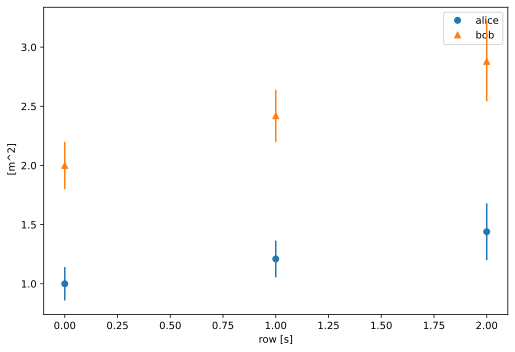

In [13]:
from scipp.plot import plot
plot(d)

This plot demonstrates the advantage of "labeled" data, provided by a dataset:
Axes are automatically labeled and multiple items identified by their name are plotted.
Furthermore, scipp's support for units and uncertainties means that all relevant information is directly included in a default plot.

Operations between rows are supported by indexing into a dataset with a dimension label and an index.

Slicing dimensions behaves similar to `numpy`:
If a single index is given, the dimension is dropped, if a range is given, the dimension is kept.
For a `Dataset`, in the former case the corresponding coordinates are dropped, whereas in the latter case it is preserved:

In [14]:
a = np.arange(8)

In [15]:
a[4]

4

In [16]:
a[4:5]

array([4])

In [17]:
d['row', 1] += d['row', 2]
sc.table(d)

Note the key advantage over `numpy` or `MATLAB`:
We specify the index dimension, so we always know which dimension we are slicing.
The advantage is not so apparent in 1D, but will become clear once we move to higher-dimensional data.

### Summary

There is a number of ways to select and operate on a single row, a range of rows, a single variable (column) or multiple variables (columns) of a dataset: 

In [18]:
# Single row (dropping corresponding coordinates)
sc.table(d['row', 0])
# Size-1 row range (keeping corresponding coordinates)
sc.table(d['row', 0:1])
# Range of rows
sc.table(d['row', 1:3])
# Single column (column pair if variance is present) including coordinate columns
sc.table(d["alice"])
# Single variable (column pair if variance is present)
sc.table(d["alice"].data)
# Column values without header
sc.table(d["alice"].values)

### Exercise 1
1. Combining row slicing and "column" indexing, add the last row of the data for `'alice'` to the first row of data for `'bob'`.
2. Using the slice-range notation `a:b`, try adding the last two rows to the first two rows. Why does this fail?

### Solution 1

In [19]:
d['bob']['row', 0] += d['alice']['row', -1]
sc.table(d)

If a range is given when slicing, the corresponding coordinate is preserved, and operations between misaligned data is prevented.

In [20]:
try:
    d['bob']['row', 0:2] += d['alice']['row', 1:3]
except RuntimeError as e:
    print(str(e))

Expected coords to match.


To circumvent the safety catch we can operate on the underlying variables containing the data.
The data is accessed using the `data` property:

In [21]:
d['bob']['row', 0:2].data += d['alice']['row', 1:3].data
sc.table(d)

### Exercise 2

The slicing notation for variables (columns) and rows does not return a copy, but a view object.
This is very similar to how `numpy` operates:

In [22]:
a_slice = a[0:3]
a_slice += 100
a

array([100, 101, 102,   3,   4,   5,   6,   7])

Using the slicing notation, create a new table (or replace the existing dataset `d`) by one that does not contain the first and last row of `d`.

### Solution 2

In [23]:
d2 = d['row', 1:-1].copy()

# Or:
# from copy import copy
# table = copy(d['row', 1:-1])

sc.table(d2)

Note that the call to `copy()` is essential.
If it is omitted we simply have a view onto the same data, and the orignal data is modified if the view is modified:

In [24]:
just_a_view = d['row', 1:-1]
just_a_view['alice'].values[0] = 666
sc.table(d)

### Appending rows and columns
We can append rows using `concatenate`, and add columns using `merge`:

In [25]:
d = sc.concatenate(d['row', 0:3], d['row', 1:3], 'row')

eve = sc.Dataset({'eve': sc.Variable(['row'], values=np.arange(5).astype(np.float64))})
d = sc.merge(d, eve)

sc.table(d)

### Exercise 3
Add the sum of the data for `alice` and `bob` as a new variable (column) to the dataset.

### Solution 3

In [26]:
d['sum'] = d['alice'] + d['bob']
sc.table(d)

### Interaction with `numpy` and scalars

Values (or variances) in a dataset are exposed in a `numpy`-compatible buffer format.
Direct access to the `numpy`-like underlying data array is possible using the `values` and `variances` properties:

In [27]:
d['eve'].values

array([0., 1., 2., 3., 4.])

In [28]:
d['alice'].variances

array([0.02  , 0.0818, 0.0576, 0.0818, 0.0576])

We can directly hand the buffers to `numpy` functions:

In [29]:
d['eve'].values = np.exp(d['eve'].values)
sc.table(d)

### Exercise 4
1. As above for `np.exp` applied to the data for Eve, apply a `numpy` function to the data for Alice.
2. What happens to the unit and uncertanties when modifying data with external code such as `numpy`?

### Solution 4

In [30]:
d['alice'].values = np.sin(d['alice'].values)
sc.table(d)

Numpy operations are not aware of the unit and uncertainties. Therefore the result is "garbage", unless the user has ensured herself that units and uncertainties are handled manually.

Corollary: Whenever available, built-in operators and functions should be preferred over the use of `numpy`.

### Exercise 5
1. Try adding a scalar value such as `1.5` to the `values` for `'eve'` or and `'alice'`.
2. Try the same using the `data` property, instead of the `values` property.
   Why is it not working for `'alice'`?

### Solution 5

In [31]:
d['eve'].values += 1.5
d['alice'].values += 1.5
sc.table(d)

Instead of `values` we can use the `data` property.
This will also correctly deal with variances, if applicable, whereas the direction operation with `values` is unaware of the presence of variances:

In [32]:
d['eve'].data += 1.5

The `data` for Alice has a unit, so a direct addition with a dimensionless quantity fails:

In [33]:
try:
    d['alice'].data += 1.5
except RuntimeError as e:
    print(str(e))

Cannot add m^2 and dimensionless.


We can use `Variable` to provide a scalar quantity with attached unit:

In [34]:
scale = sc.Variable(value=1.5, unit=sc.units.m*sc.units.m)

As a short-hand for creating a scalar variable, just multiply a value by a unit:

In [35]:
scale = 1.5 * (sc.units.m*sc.units.m)
d['alice'].data += scale

sc.table(d)

Continue to [Part 2 - Multi-dimensional datasets](multi-d-datasets.ipynb) to see how datasets are used with multi-dimensional data.